# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
import boto3
client = boto3.client('s3')
path = 's3://classdataset/CowboyCigsData.csv'
df = pd.read_csv(path)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
df.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
df.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [5]:
df.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [6]:
df.isnull().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
del df['Unnamed: 0']

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
df.rename(columns={'Time': 'Month', '#CigSales': 'Cig_Sales'}, inplace=True)

Call a head() to check this has worked. 

In [9]:
df.head()

,Month,Cig_Sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
df['Month'] = pd.to_datetime(df['Month'])

In [11]:
df.dtypes

Month        datetime64[ns]
Cig_Sales             int64
dtype: object

In [12]:
df = df.set_index('Month')

In [13]:
df.head()

,Cig_Sales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [14]:
y = df['Cig_Sales']

Check the type of our new variable. 

In [15]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [16]:
y.describe().apply(lambda x: '%.2f' % x)

count        144.00
mean     1000280.30
std          119.97
min      1000104.00
25%      1000180.00
50%      1000265.50
75%      1000360.50
max      1000622.00
Name: Cig_Sales, dtype: object

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

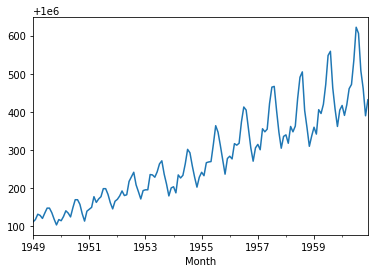

In [17]:
y.plot()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [18]:
import statsmodels.api as sm

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

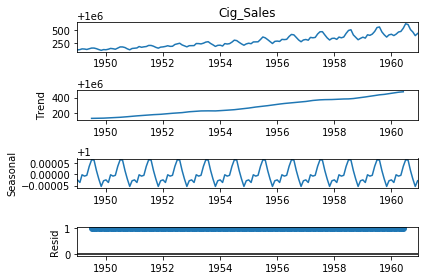

In [19]:
fig = decomposition.plot()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [21]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")
result = kpss(y)
result[1]

0.01

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

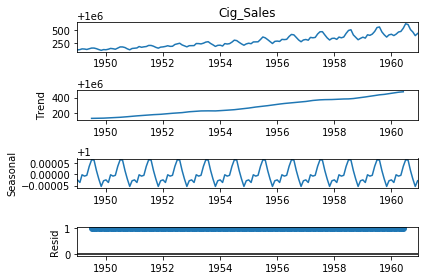

In [22]:
fig = decomposition.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [23]:
y

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
               ...   
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Name: Cig_Sales, Length: 144, dtype: int64

In [24]:
y_log = np.log(y)
y_log

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
                ...    
1960-08-01    13.816116
1960-09-01    13.816018
1960-10-01    13.815971
1960-11-01    13.815900
1960-12-01    13.815942
Name: Cig_Sales, Length: 144, dtype: float64


When you plot this, you can see how the variance in our data now remains contant over time.

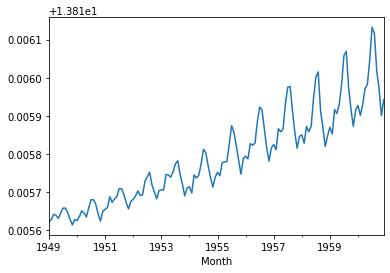

In [25]:
y_log.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [30]:
import warnings
warnings.filterwarnings("ignore")
y_diff = y_log.diff().dropna()
kpss(y_diff)[1]

0.1

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

## Model Selection

#### Using ACF and PACF to decide which model to use (AR / MA / ARMA)

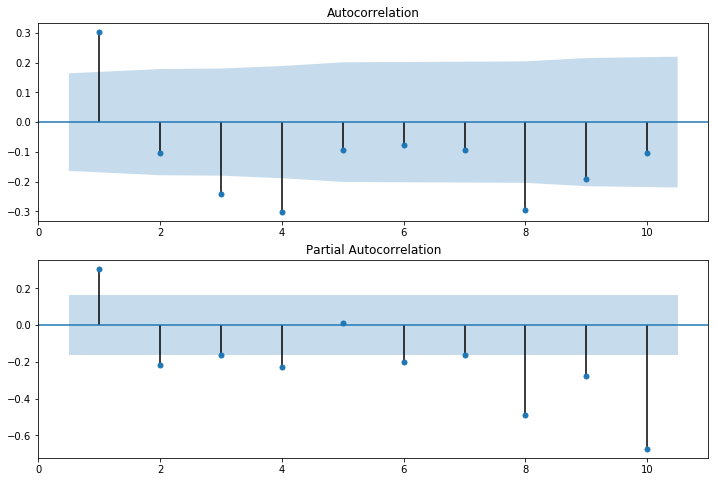

In [32]:
# Let's use ACF and PACF plots to decide the type of model (AR / MA / ARMA)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot the ACF 
plot_acf(y_diff, lags=10, zero=False, ax=ax1)
# Plot the PACF
plot_pacf(y_diff, lags=10, zero=False, ax=ax2)
plt.show()

Both ACF and PACF tail off therefore the ARMA model makes more sense! Now the question becomes, what order of ARMA model? 

In order to determine the order of ARMA model, AIC and BIC can be used to make the selection.

#### Use AIC and BIC to choose the order of the Model (p, q)

AIC: 
* Lower AIC indicates a better model
* AIC likes to choose simple models with lower order

BIC:
* Lower BIC indicates a better model
* BIC likes to choose simple models with lower order

AIC vs BIC:
* The main difference between these two is how much they penalize the model. BIC penalizes the model orders more than AIC. BIC favors simpler models than AIC.
* AIC is better at choosing predictive models
* BIC is better at choosing good explanatory models

In [28]:
# Forecasting out of sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
# Instantiate ARIMA model
model = SARIMAX(y, order=(2,1,1))
# Fit the model
results = model.fit()
# Print AIC and BIC
print('AIC: ', results.aic)
print('BIC: ', results.bic)

AIC:  1416.176428053135
BIC:  1428.0278065741745


In [33]:
# Searching over AIC and BIC
# Loop over AR order
for p in range(3):
    #Loop over MA order
    for q in range(3):
        # fit model
        model = SARIMAX(y_diff, order=(p,0,q))
        results = model.fit()
        # print the model order and the AIC, BIC values
        print('AR order: {}, MA order: {}, AIC: {}, BIC: {}'.format(p, q, results.aic, results.bic))

AR order: 0, MA order: 0, AIC: -2537.438092975799, BIC: -2534.475248345539
AR order: 0, MA order: 1, AIC: -2553.604665775445, BIC: -2547.678976514925
AR order: 0, MA order: 2, AIC: -2552.417119550677, BIC: -2543.528585659897
AR order: 1, MA order: 0, AIC: -2549.491433083028, BIC: -2543.565743822508
AR order: 1, MA order: 1, AIC: -2550.792270625643, BIC: -2541.9037367348633
AR order: 1, MA order: 2, AIC: -2558.3256652286923, BIC: -2546.4742867076525
AR order: 2, MA order: 0, AIC: -2554.8491707684975, BIC: -2545.9606368777177
AR order: 2, MA order: 1, AIC: -2561.64924755283, BIC: -2549.79786903179
AR order: 2, MA order: 2, AIC: -2559.5449141247173, BIC: -2544.7306909734175


ARMA(2,1) models seems to have the lowest AIC and BIC values

In [39]:
model = SARIMAX(y_diff, order=(2,0,1))
results = model.fit()
forecast = results.get_forecast(steps=20)
# Calculate mean of forecast
mean_forecast = forecast.predicted_mean
# Confidence intervals of forecasts
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Cig_Sales']
upper_limits = confidence_intervals.loc[:,'upper Cig_Sales']

In [40]:
# residuals
residuals = results.resid
# Mean Absolute Error
mae = np.mean(np.abs(residuals))
mae

2.402984304330996e-05

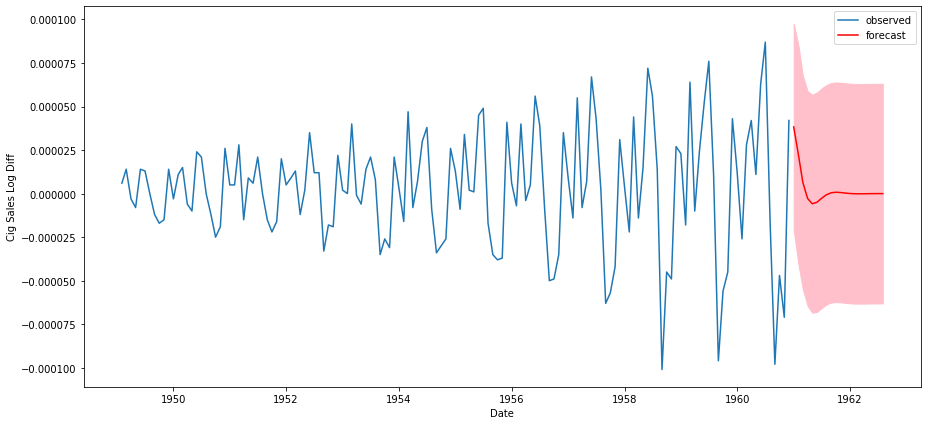

In [35]:
_ = plt.figure(figsize=(15,7))
_ = plt.plot(y_diff.index, y_diff.values, label='observed')
_ = plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
_ = plt.fill_between(lower_limits.index, lower_limits.values, upper_limits.values, color='pink')
_ = plt.xlabel('Date')
_ = plt.ylabel('Cig Sales Log Diff')
_ = plt.legend(loc='best')
plt.show()

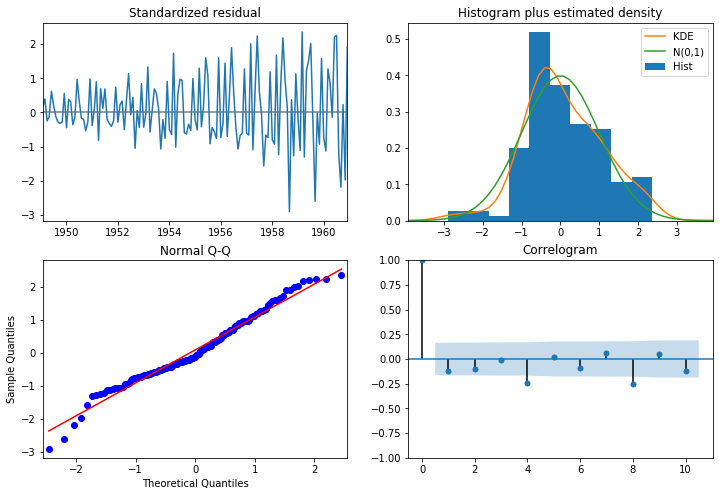

In [44]:
# Diagnostic plots
results.plot_diagnostics(figsize=(12,8))
plt.show()

All of the graphs show that model can be further improved! I can see there is a trend in Standardized residual that the model wasn't able to capture. From the Histogram, KDE is not aligned with the normal distribution. In Q-Q plot, the data points don't perfectly align with the straight line. And there are lags that fall outside the 95% confidence interval. 

## In-sample Prediction

In [104]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
# Instantiate ARMA model + constant 
model = SARIMAX(y_diff, order=(2,0,1), trend='c')
# Fit the model
results = model.fit()
# Make in-sample predictions for last 25 entries
forecast = results.get_prediction(start=-25)
# Forecast mean
mean_forecast = forecast.predicted_mean
# Confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

In [52]:
lower_limits = confidence_intervals.loc[:,'lower Cig_Sales']
upper_limits = confidence_intervals.loc[:,'upper Cig_Sales']

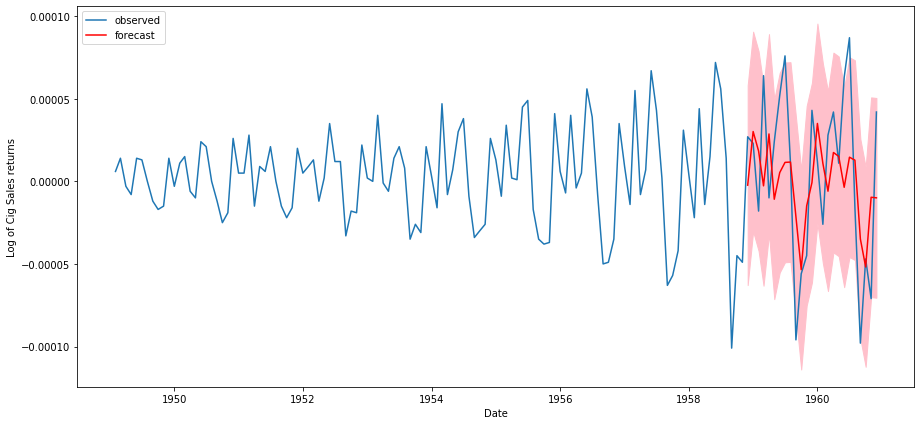

In [54]:
_ = plt.figure(figsize=(15,7))
_ = plt.plot(y_diff.index, y_diff.values, label='observed')
_ = plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
_ = plt.fill_between(lower_limits.index, lower_limits.values, upper_limits.values, color='pink')
_ = plt.xlabel('Date')
_ = plt.ylabel('Log of Cig Sales returns')
_ = plt.legend(loc='best')
plt.show()

### Dynamic Prediction

In [55]:
# Dynamic predictions
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
# Instantiate ARMA model + constant 
model = SARIMAX(y_diff, order=(2,0,1), trend='c')
# Fit the model
results = model.fit()
# Make in-sample predictions for last 25 entries
forecast = results.get_prediction(start=-25, dynamic=True)
# Forecast mean
mean_forecast = forecast.predicted_mean
# Confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

In [58]:
lower_limits = confidence_intervals.loc[:,'lower Cig_Sales']
upper_limits = confidence_intervals.loc[:,'upper Cig_Sales']

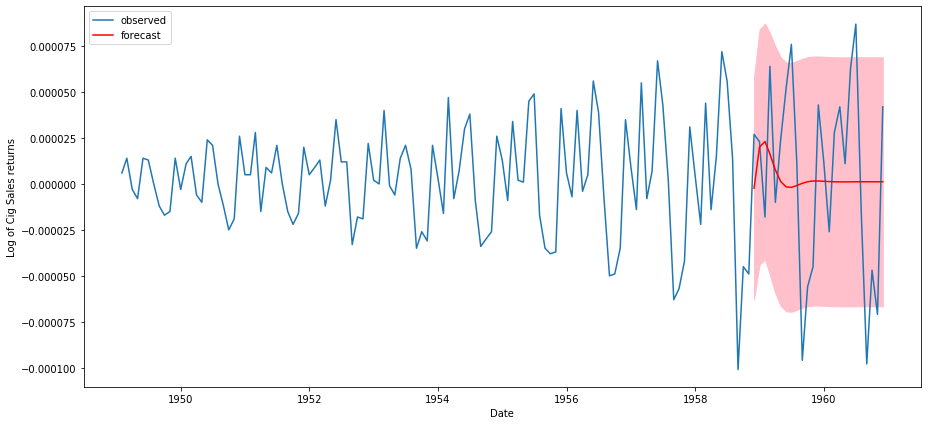

In [59]:
_ = plt.figure(figsize=(15,7))
_ = plt.plot(y_diff.index, y_diff.values, label='observed')
_ = plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
_ = plt.fill_between(lower_limits.index, lower_limits.values, upper_limits.values, color='pink')
_ = plt.xlabel('Date')
_ = plt.ylabel('Log of Cig Sales returns')
_ = plt.legend(loc='best')
plt.show()

### Forecasting out of sample

In [69]:
# Forecasting out of sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
# Instantiate ARMA model + constant 
model = SARIMAX(y_diff, order=(2,0,1), trend='c')
# Fit the model
results = model.fit()
# Make out-of-sample forecast for 20 entries beyond the last entry of the series
forecast = results.get_forecast(steps=20)
# Forecast mean
mean_forecast = forecast.predicted_mean
# Confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

In [70]:
lower_limits = confidence_intervals.loc[:,'lower Cig_Sales']
upper_limits = confidence_intervals.loc[:,'upper Cig_Sales']

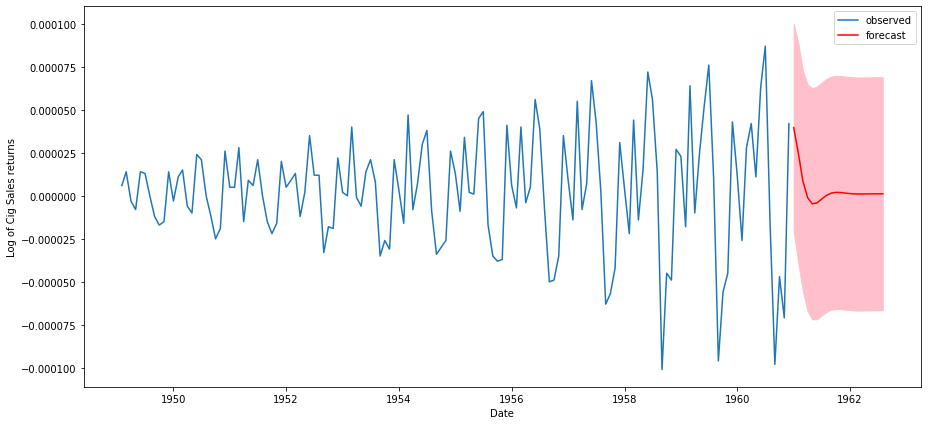

In [64]:
_ = plt.figure(figsize=(15,7))
_ = plt.plot(y_diff.index, y_diff.values, label='observed')
_ = plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
_ = plt.fill_between(lower_limits.index, lower_limits.values, upper_limits.values, color='pink')
_ = plt.xlabel('Date')
_ = plt.ylabel('Log of Cig Sales returns')
_ = plt.legend(loc='best')
plt.show()

In [71]:
mean_forecast

1961-01-01    3.965841e-05
1961-02-01    2.430065e-05
1961-03-01    8.775650e-06
1961-04-01   -1.050969e-06
1961-05-01   -4.652729e-06
1961-06-01   -4.107204e-06
1961-07-01   -1.893894e-06
1961-08-01    2.485459e-07
1961-09-01    1.562238e-06
1961-10-01    2.013548e-06
1961-11-01    1.908030e-06
1961-12-01    1.590593e-06
1962-01-01    1.295623e-06
1962-02-01    1.120489e-06
1962-03-01    1.064540e-06
1962-04-01    1.083158e-06
1962-05-01    1.128486e-06
1962-06-01    1.169005e-06
1962-07-01    1.192285e-06
1962-08-01    1.199131e-06
Freq: MS, dtype: float64

In [72]:
# Integrate the difference
mean_forecast_cum = np.cumsum(mean_forecast)

In [73]:
mean_forecast_cum

1961-01-01    0.000040
1961-02-01    0.000064
1961-03-01    0.000073
1961-04-01    0.000072
1961-05-01    0.000067
1961-06-01    0.000063
1961-07-01    0.000061
1961-08-01    0.000061
1961-09-01    0.000063
1961-10-01    0.000065
1961-11-01    0.000067
1961-12-01    0.000068
1962-01-01    0.000070
1962-02-01    0.000071
1962-03-01    0.000072
1962-04-01    0.000073
1962-05-01    0.000074
1962-06-01    0.000075
1962-07-01    0.000076
1962-08-01    0.000078
Freq: MS, dtype: float64

In [75]:
# Make the original value of y
cig_sales = mean_forecast_cum + df.iloc[-1,0]

In [76]:
cig_sales

1961-01-01    1.000432e+06
1961-02-01    1.000432e+06
1961-03-01    1.000432e+06
1961-04-01    1.000432e+06
1961-05-01    1.000432e+06
1961-06-01    1.000432e+06
1961-07-01    1.000432e+06
1961-08-01    1.000432e+06
1961-09-01    1.000432e+06
1961-10-01    1.000432e+06
1961-11-01    1.000432e+06
1961-12-01    1.000432e+06
1962-01-01    1.000432e+06
1962-02-01    1.000432e+06
1962-03-01    1.000432e+06
1962-04-01    1.000432e+06
1962-05-01    1.000432e+06
1962-06-01    1.000432e+06
1962-07-01    1.000432e+06
1962-08-01    1.000432e+06
Freq: MS, dtype: float64

## ARIMA Model

* Take the difference
* Fit ARMA model
* Integrate forecast


In [65]:
# Forecasting out of sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
# Instantiate ARIMA model
model = SARIMAX(y, order=(2,1,1))
# Fit the model
results = model.fit()
# Make out-of-sample forecast for 20 entries beyond the last entry of the series
forecast = results.get_forecast(steps=20)
# Forecast mean
mean_forecast = forecast.predicted_mean
# Confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

In [66]:
lower_limits = confidence_intervals.loc[:,'lower Cig_Sales']
upper_limits = confidence_intervals.loc[:,'upper Cig_Sales']

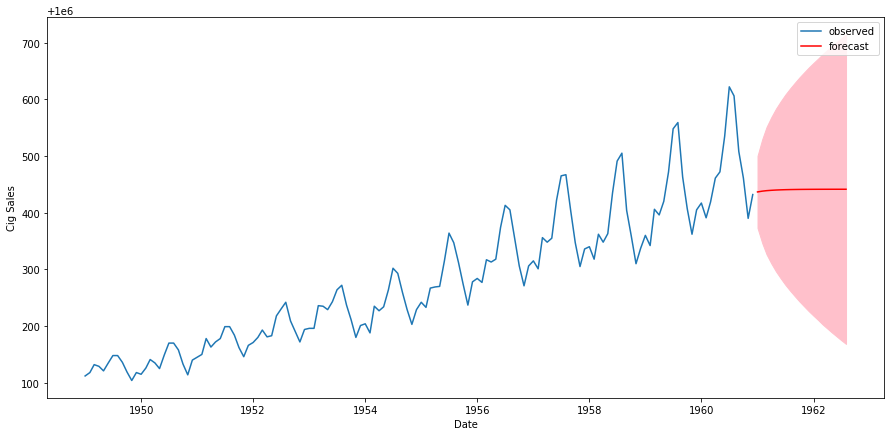

In [68]:
_ = plt.figure(figsize=(15,7))
_ = plt.plot(y.index, y.values, label='observed')
_ = plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
_ = plt.fill_between(lower_limits.index, lower_limits.values, upper_limits.values, color='pink')
_ = plt.xlabel('Date')
_ = plt.ylabel('Cig Sales')
_ = plt.legend(loc='best')
plt.show()

## Another way of implementing ARIMA Model

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [156]:
def calc_mse(data, arima_order):
    """A function that calculates the MSE of a single ARIMA model"""
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future) 
        past.append(test[i]) # changing the past by adding a data point from the test set
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [160]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def eval_arima(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = calc_mse(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [161]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [163]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
eval_arima(y_diff, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
Best ARIMA(2, 0, 1) MSE=0.000


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [166]:
model = ARIMA(y_diff, order = (2, 0, 1))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [167]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Cig_Sales   No. Observations:                  143
Model:                     ARMA(2, 1)   Log Likelihood                1263.116
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 30 Sep 2020   AIC                          -2516.233
Time:                        23:29:21   BIC                          -2501.418
Sample:                    02-01-1949   HQIC                         -2510.213
                         - 12-01-1960                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.624e-06   5.06e-07      5.184      0.000    1.63e-06    3.62e-06
ar.L1.Cig_Sales     0.4681      0.156      3.003      0.003       0.163       0.774
ar.L2.Cig_Sales    -0.2640      0.109     -2.413      0.016      -0.478      -0.050
ma.L1.Cig_Sales    -0.8693        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8866           -1.7326j            1.9463           -0.1747
AR.2            0.8866           +1.7326j            1.9463            0.1747
MA.1            1.1504           +0.0000j            1.1504            0.0000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

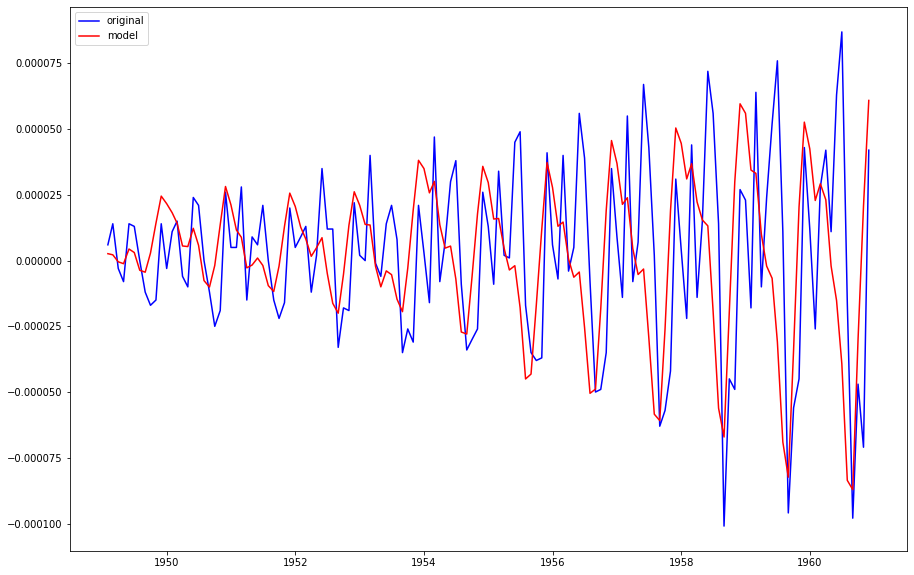

In [173]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_diff, color='blue', label='original')
plt.plot(model_fit.predict(), color = 'red', label='model')
plt.legend(loc='best')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [177]:
y_diff.index[-1]

Timestamp('1960-12-01 00:00:00')

In [181]:
pd.date_range(y_diff.index[-1], periods=12, freq='MS').strftime("%Y-%m-%d").tolist()

['1960-12-01',
 '1961-01-01',
 '1961-02-01',
 '1961-03-01',
 '1961-04-01',
 '1961-05-01',
 '1961-06-01',
 '1961-07-01',
 '1961-08-01',
 '1961-09-01',
 '1961-10-01',
 '1961-11-01']

In [185]:
len(forecast[0])

24

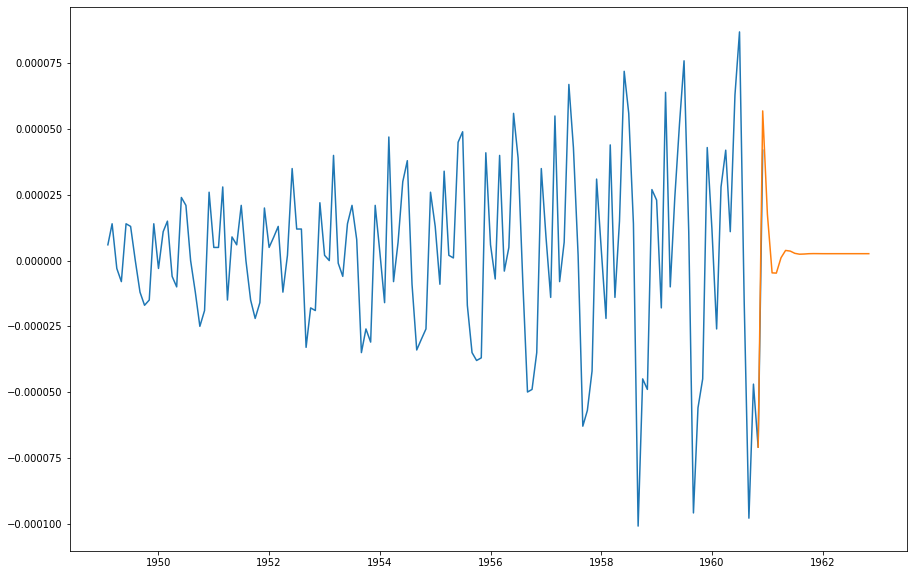

In [186]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(y_diff.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_diff)
plt.plot(y_diff['Nov 1960'].append(future_months['Prediction']))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 